In [1]:
import pandas as pd
import numpy as nd
import csv
import matplotlib.pyplot as plt
from math import ceil
from sklearn.linear_model import LinearRegression
from typing import Union, Optional
from pathlib import Path
from contextlib import contextmanager
from matplotlib.ticker import MaxNLocator

DIR=Path("../csv/dns")

ROW_TRANS = {
    "target_year": int,
    "target_value": float,
    "lower_is_better": lambda x: x.lower() == "true",
}
DEFAULT_TRANS = lambda x: x

In [2]:
@contextmanager
def dr(infile: Union[Path, str]):
    try:
        inf = open(infile, "r")
        dialect = csv.Sniffer().sniff(inf.read(1024))
        inf.seek(0)
        dr = csv.DictReader(inf, dialect=dialect)
        yield dr
    finally:
        inf.close()

In [3]:
def process_target(row):
    """
    Reads the CSV file indicated by row, and returns a tuple: UNIT, DATAFRAME.
    
    The dataframe has the columns 'year', and 'value.
    #:param row: The row from the _targets.csv file
    :returns: unit:str, DataFrame
    """
    #print(f"PROCESSING '{row['goal_code']}' ...")
    df = pd.read_csv(DIR / (row["goal_code"] + ".csv"), sep=",")
    df.rename(
        columns={
            "Time Series": "series",
            "Time series": "series",
            "Series": "series",
            "Year": "year",
            "Value": "value",
            "Units": "units",
            "Calculation method": "series", # 17-1
        },
        inplace=True)
        
    keep_cols = ("year", "value")
    ignore_cols = ("year", "value", "units")

    # choose a specific series if needed
    if val := row["time_series"]:
        #print(f"    - Selecting series: '{val}'")
        df = df[df["series"].isin(val.split("|"))]
        df.drop(columns=("series"), inplace=True)
    elif "series" in df.columns.values:
        #print(f"    - Selecting series.isna()")
        df = df.loc[df["series"].isna()]
        df.drop(columns=("series"), inplace=True)

    # select all nan columns
    for val in df.columns.values:
        if val in ignore_cols:
            continue
        #print(f"    - Selecting isna() values for: {val}")
        df = df[df[val].isna()]
    
    # get the unit
    units = df["units"].unique()
    if not len(units):
        unit = "---"
    else:
        unit = [0]
    
    drop_cols = list(set(df.columns.values) - set(keep_cols))
    #print(f"    - Dropping columns: {','.join(drop_cols)}")
    df.drop(columns=drop_cols, inplace=True)

    df.dropna(inplace=True)
    
    return unit,df

In [4]:
def extrapolate(row: dict[str, Optional[str]], df:pd.DataFrame) -> float:
    # https://stackoverflow.com/a/57773572/902327
    X = df["year"].values.reshape(-1, 1)
    y = df["value"].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    line_values = model.predict(X)
    target_estimate = model.predict([[row["target_year"]]])
    return line_values, target_estimate[0][0]

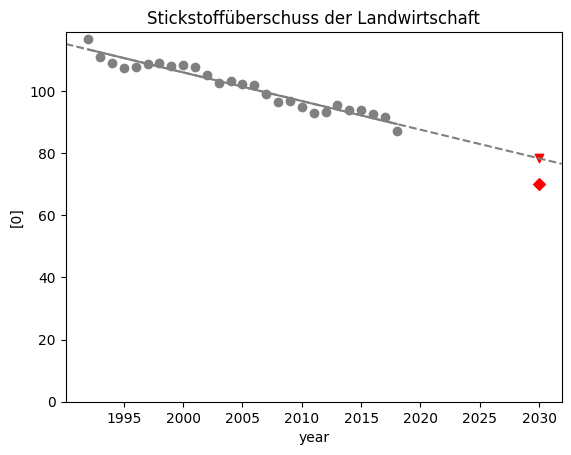

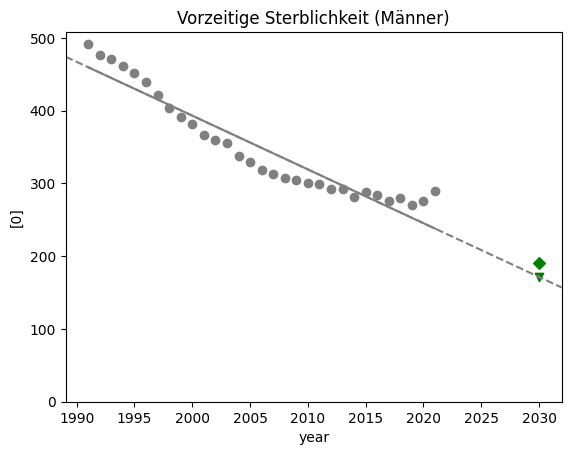

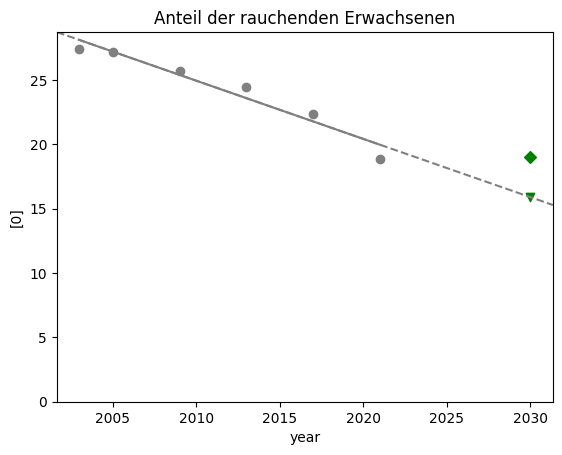

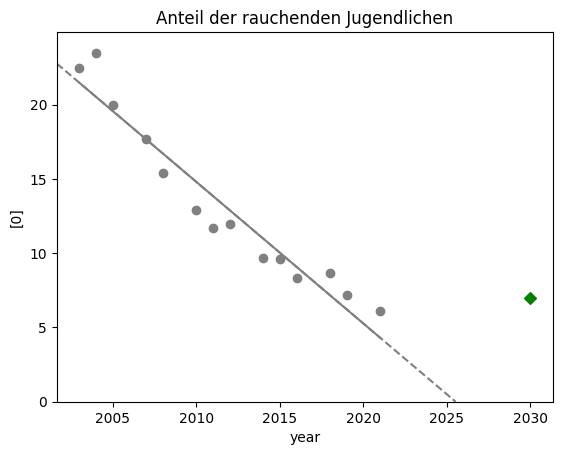

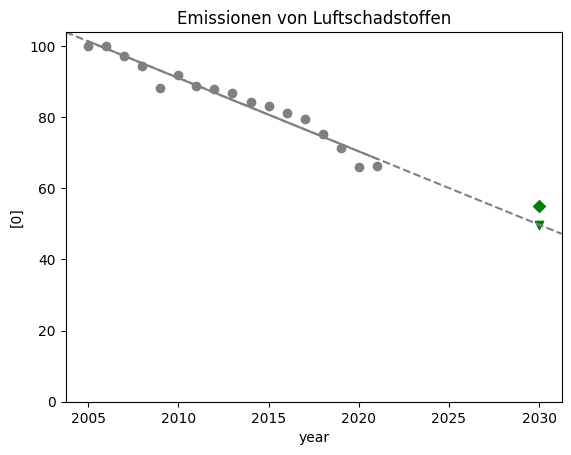

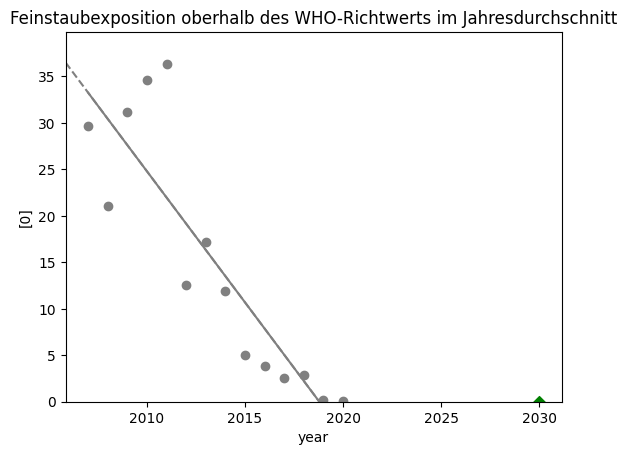

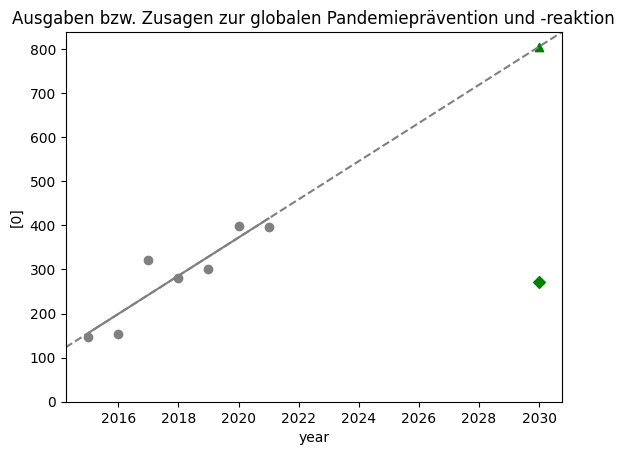

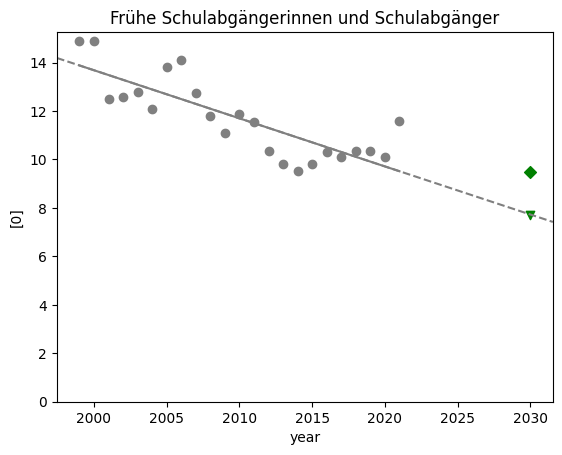

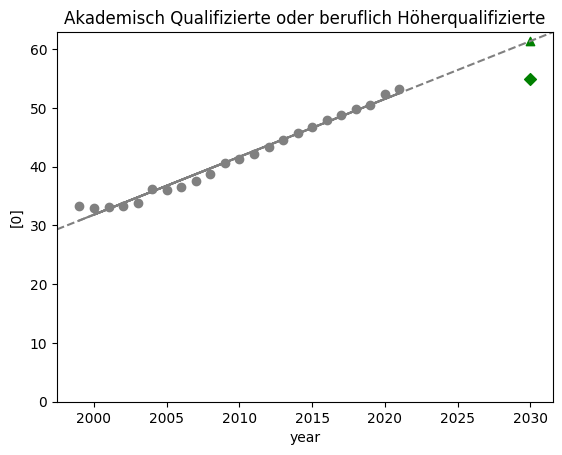

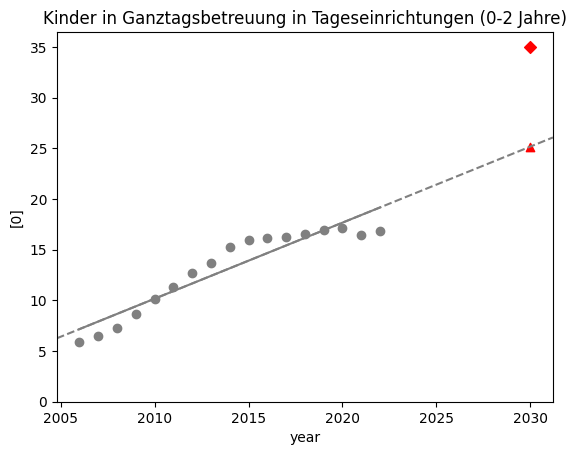

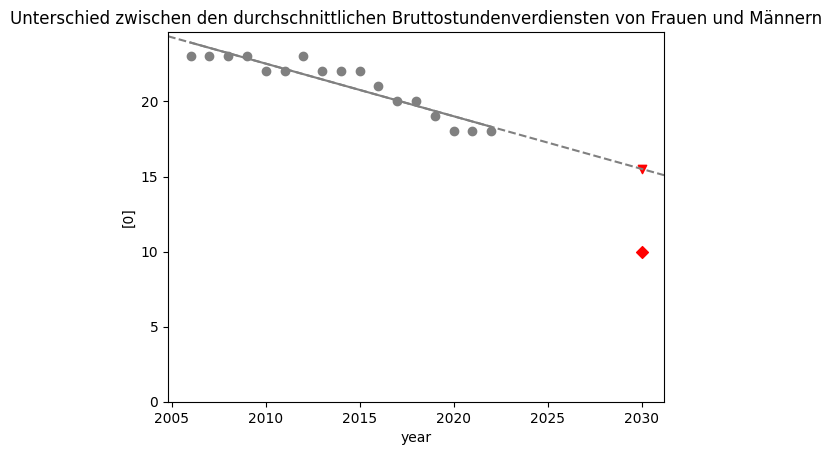

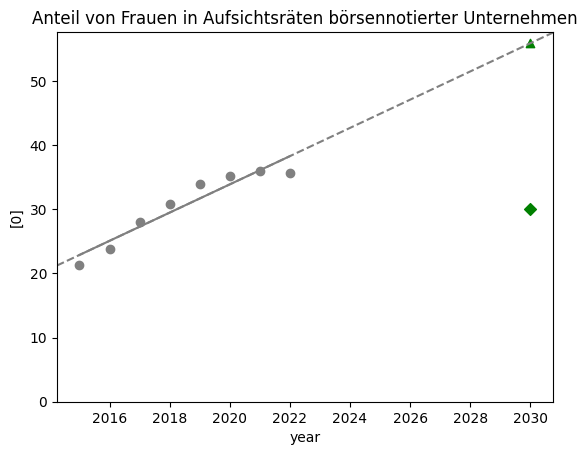

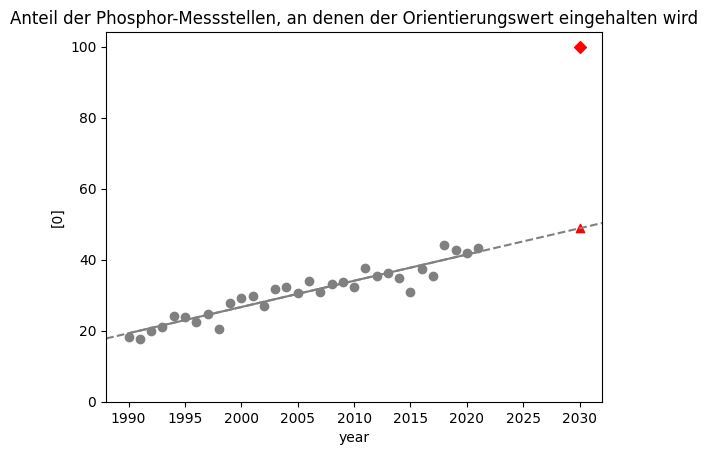

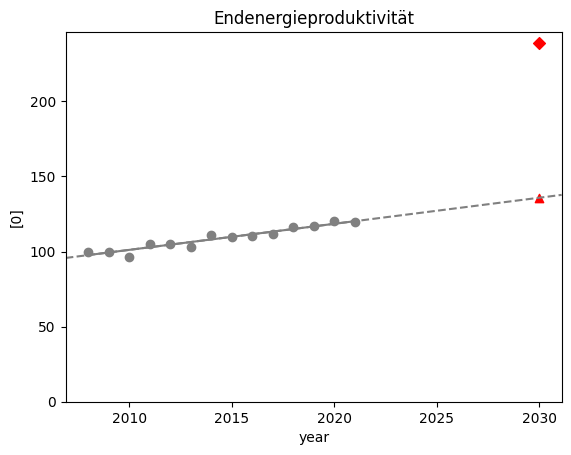

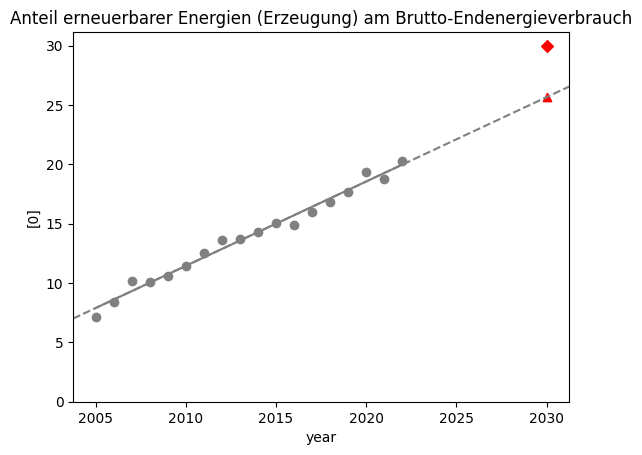

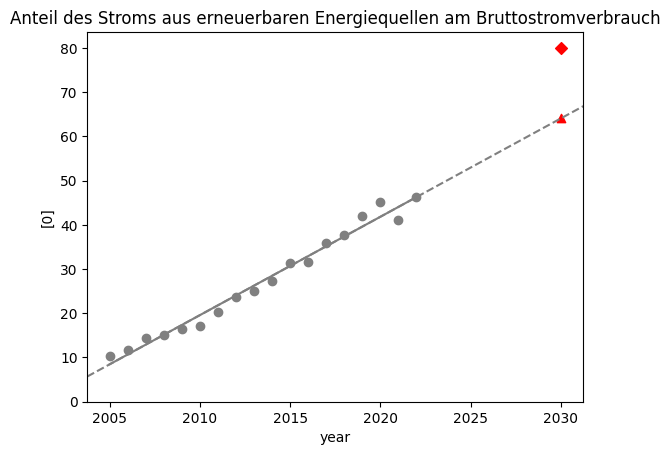

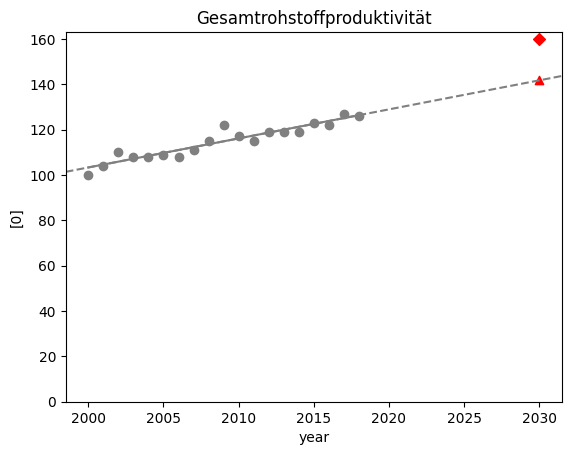

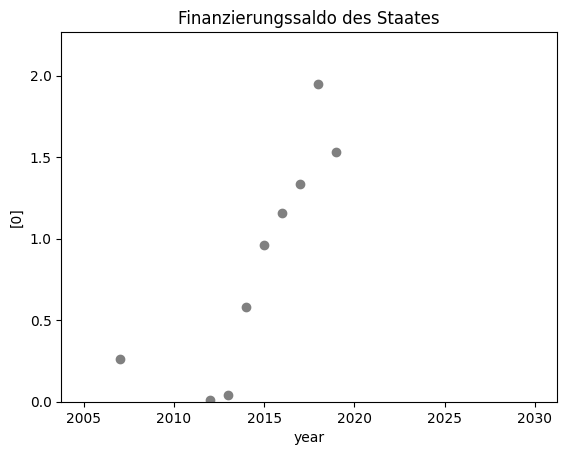

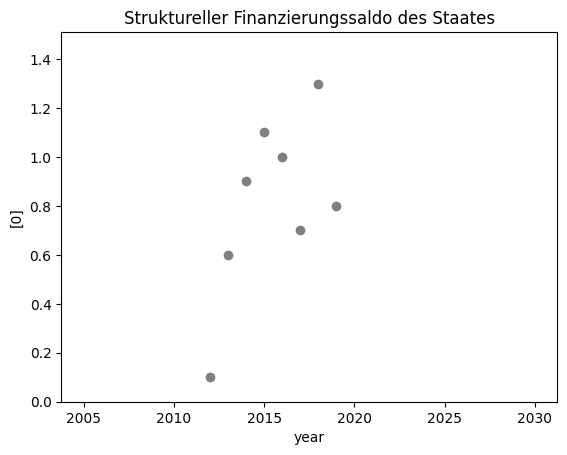

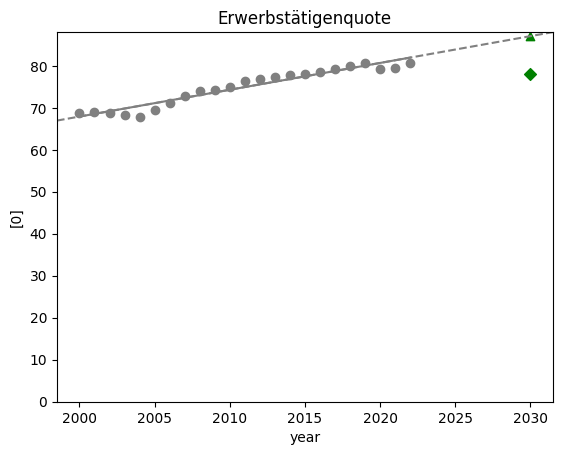

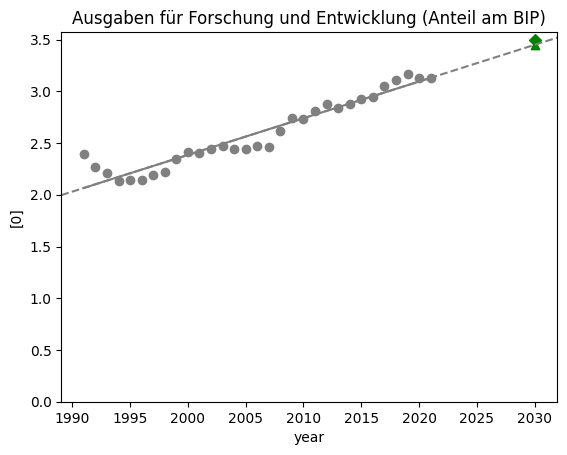

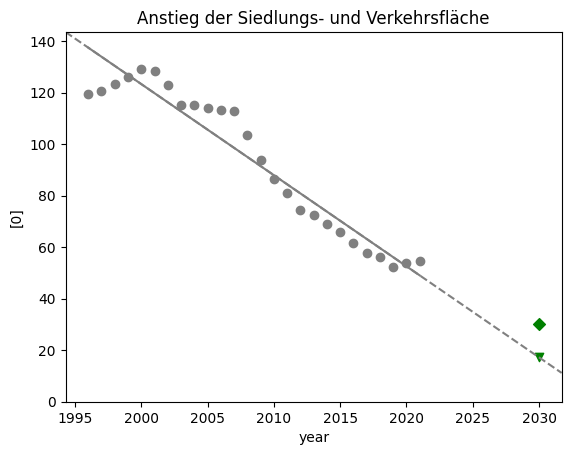

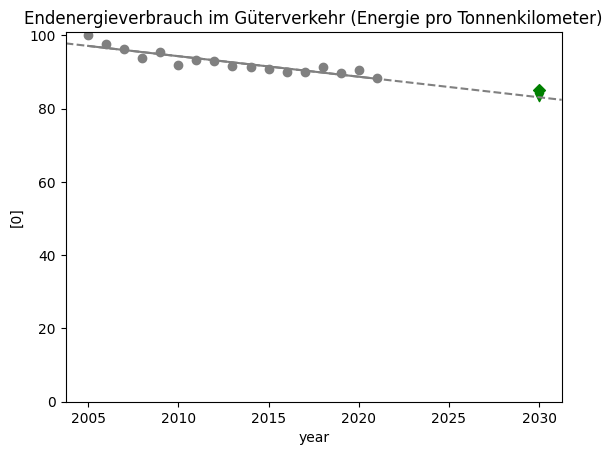

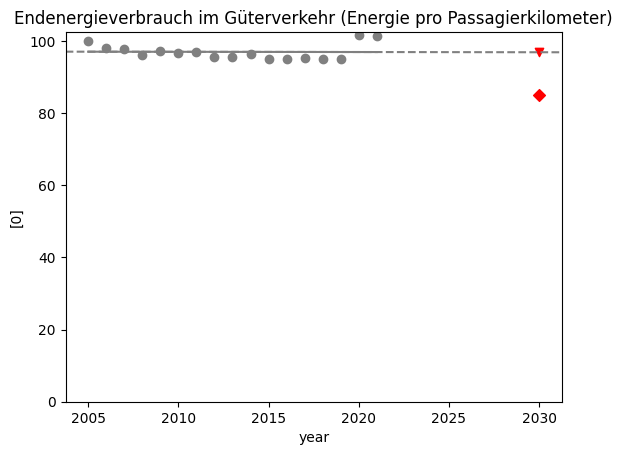

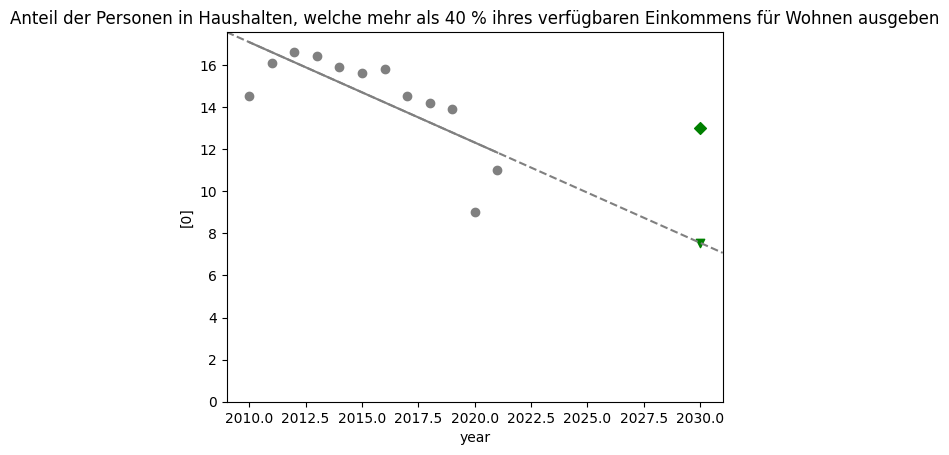

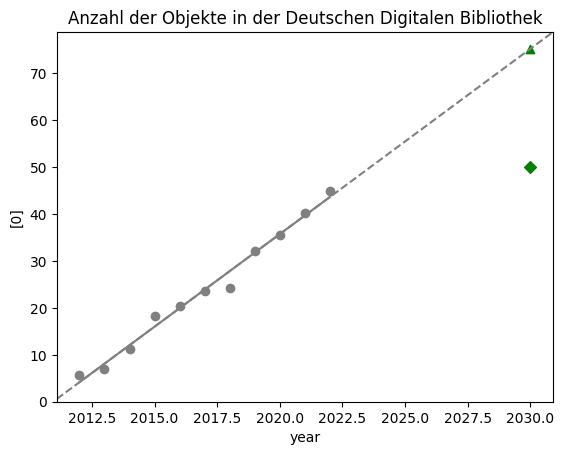

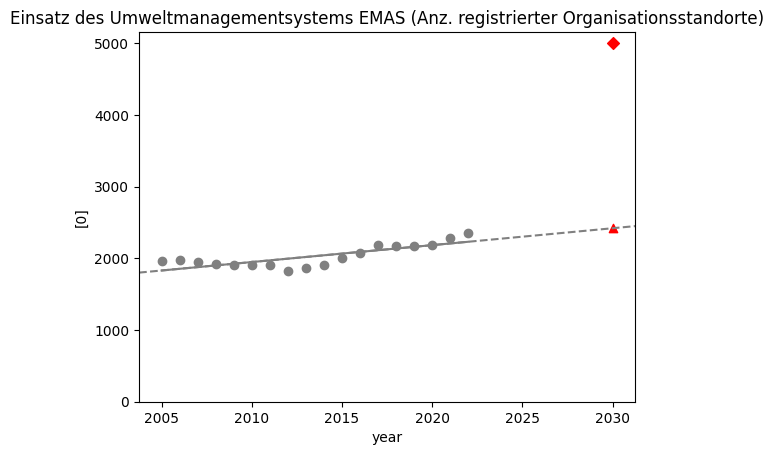

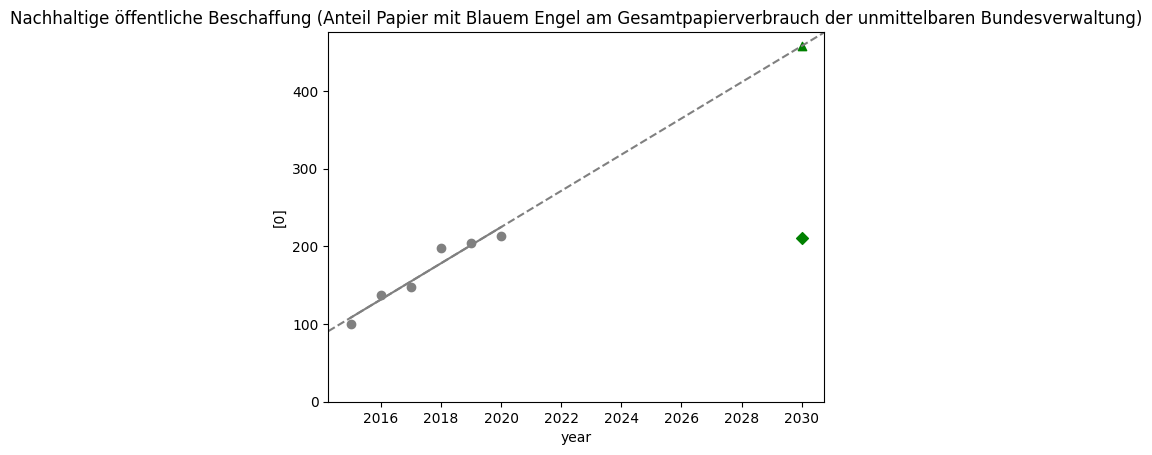

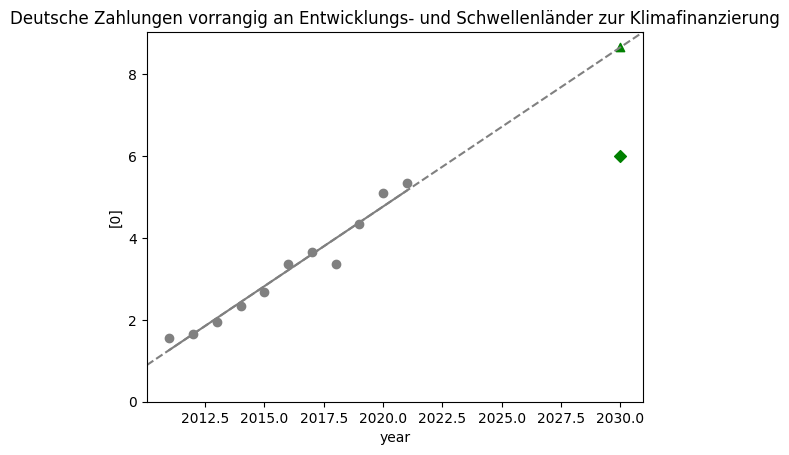

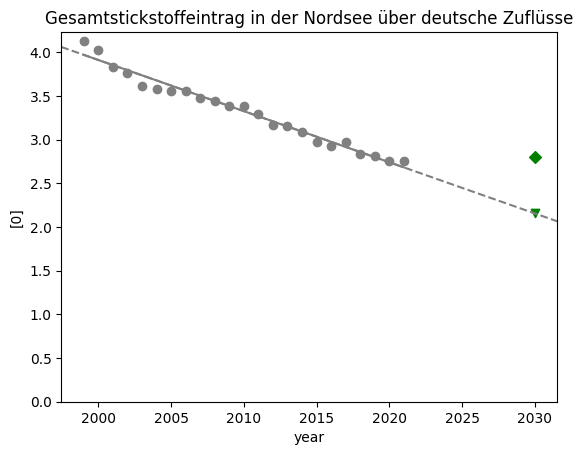

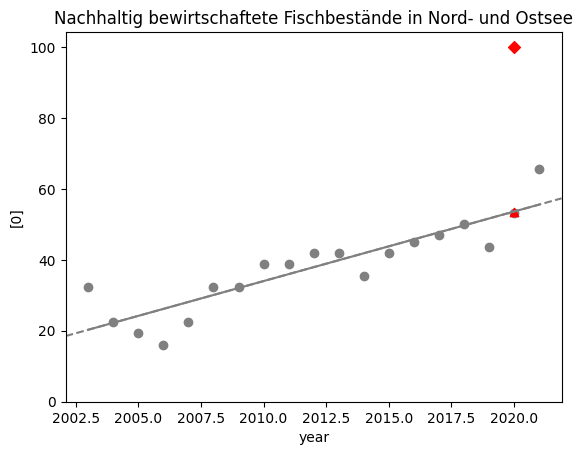

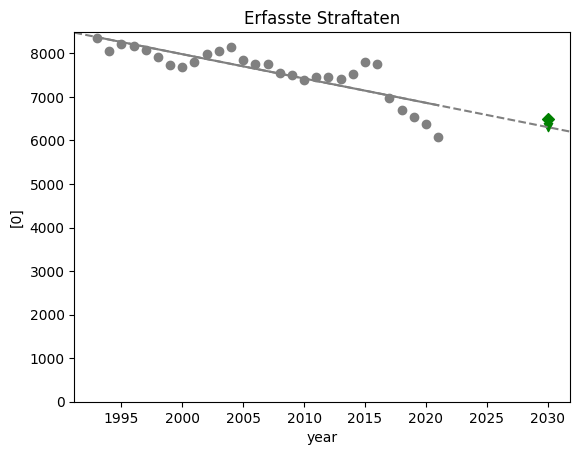

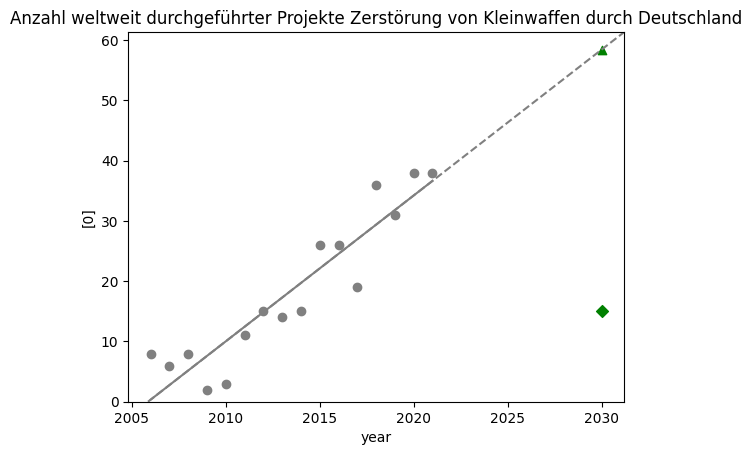

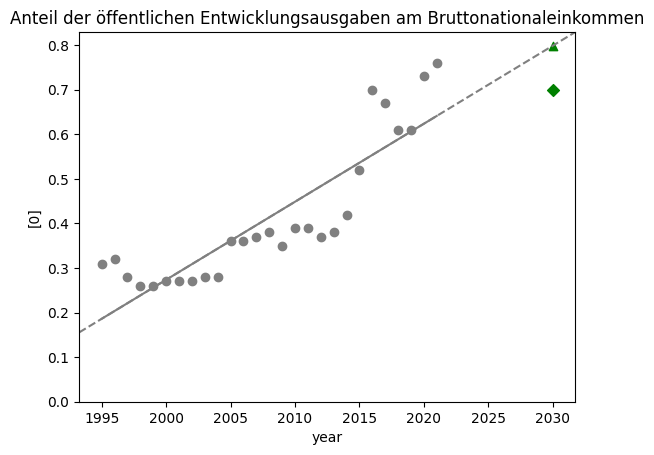

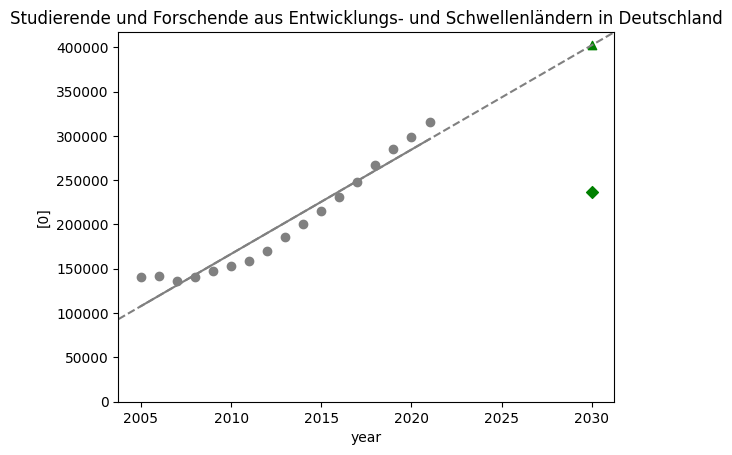

In [8]:
with dr(DIR / "_targets.csv") as reader:
    lines = [line for line in reader]

total_metrics = len(lines)

# (name, success, difficulty)
results = []
for idx, row in enumerate(lines):
    row = {k: ROW_TRANS.get(k, DEFAULT_TRANS)(v) for k, v in row.items()}
    target_value = row["target_value"]
    target_year = row["target_year"]
    lower_is_better = row["lower_is_better"]
    goal_code = row["goal_code"]
    goal_name = row["goal_name"]
    goal_difficulty = row["difficulty"]

    #if row["goal_code"] != "17-2": continue
    #if idx != 36: continue

    unit, df = process_target(row)
    
    prediction, target_estimate = extrapolate(row, df)

    grace_level = 0.1
    estimation_color = "green"
    will_succeed = "success"
    if lower_is_better:
        estimation_marker = "v"
        if target_estimate > row["target_value"] * (1 + grace_level):
            estimation_color = "red"
            will_succeed = "miss"
    else:
        estimation_marker = "^"
        if target_estimate < row["target_value"] * (1 - grace_level):
            estimation_color = "red"
            will_succeed = "miss"
    
    results.append((goal_code, goal_name, goal_difficulty, will_succeed))    
    
    #plt.subplot(ceil(total_metrics / 4), 4, idx+1)
    plt.title(row["goal_name"])
    plt.xlabel('year')
    plt.ylabel(unit)
    plt.scatter(df["year"], df["value"], color = 'gray')
    x1, y1 = df['year'].iloc[0], prediction[0][0]
    x2, y2 = row["target_year"], target_estimate
    plt.axline((x1, y1), (x2, y2), color="gray", linestyle="--")
    plt.plot(df["year"], prediction, color = "gray")
    plt.scatter(row["target_year"], target_estimate, color=estimation_color, marker=estimation_marker)
    plt.scatter(row["target_year"], row["target_value"], color=estimation_color, marker="D")
    plt.ylim(ymin=0)
    plt.show()

In [12]:
df = pd.DataFrame(results)
f = {
        2: 'nunique', 
        3: "sum",
}
# https://stackoverflow.com/a/35268906
df2 = df.groupby([2, 3]).size().reset_index().rename(columns={0:"count", 2:"difficulty", 3:"hit-or-miss"})
df2

difficulty hit-or-miss  count
0       easy     success     15
1       hard        miss     15
2       hard     success     10
3    unknown        miss      3
4    unknown     success      6

In [19]:
for p in df.loc[df[3] == "miss"][1].unique(): print(p)

Stickstoffüberschuss der Landwirtschaft
Landwirtschaftliche Fläche unter ökologischer Bewirtschaftung
Kinder in Ganztagsbetreuung in Tageseinrichtungen (0-2 Jahre)
Unterschied zwischen den durchschnittlichen Bruttostundenverdiensten von Frauen und Männern
Anteil der Phosphor-Messstellen, an denen der Orientierungswert eingehalten wird
Anteil der Nitrat-Messstellen, an denen der Schwellenwert eingehalten wird
Endenergieproduktivität
Anteil erneuerbarer Energien (Erzeugung) am Brutto-Endenergieverbrauch
Anteil des Stroms aus erneuerbaren Energiequellen am Bruttostromverbrauch
Gesamtrohstoffproduktivität
Schuldenstand im Verh. zum Bruttoinlandsprodukt in jeweiligen Preisen
Endenergieverbrauch im Güterverkehr (Energie pro Passagierkilometer)
Marktanteil von Produkten mit staatlichen Umweltzeichen
Einsatz des Umweltmanagementsystems EMAS (Anz. registrierter Organisationsstandorte)
Treibhausgasemissionen
Nachhaltig bewirtschaftete Fischbestände in Nord- und Ostsee
Bestand repräsentativer Vog

In [ ]:
df